In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# FMCW Radar: Complete Range-Doppler Processing

## Introduction

This notebook demonstrates **FMCW (Frequency-Modulated Continuous Wave) radar**—the most widely used automotive radar technology. FMCW combines continuous wave transmission with linear frequency modulation to simultaneously measure range and velocity with high accuracy and efficiency.

### FMCW Radar Principles

**What is FMCW?**

FMCW radar transmits a **chirp**—a signal whose frequency increases (or decreases) linearly over time. By mixing the transmitted and received signals, the radar extracts both range and velocity through **beat frequency analysis**.

**Basic Operation:**

1. **Transmit Chirp**: Linear frequency sweep (e.g., 24.075 → 24.175 GHz)
2. **Receive Reflected Signal**: Delayed and Doppler-shifted echo from target
3. **Mixing**: Multiply TX and RX signals → Beat frequency
4. **Range Extraction**: Beat frequency proportional to range
5. **Doppler Extraction**: Phase change across chirps reveals velocity

### Beat Frequency and Range

**Range Measurement:**

When the transmitted chirp reflects from a target at range $R$, the received signal is delayed by:

$$\tau = \frac{2R}{c}$$

Where:
- $\tau$ = Round-trip delay (seconds)
- $R$ = Target range (m)
- $c$ = Speed of light (3×10⁸ m/s)

**Beat Frequency:**

The frequency difference between TX and RX at any instant is:

$$f_b = \frac{B \cdot \tau}{T_c} = \frac{2RB}{cT_c}$$

Where:
- $f_b$ = Beat frequency (Hz)
- $B$ = Chirp bandwidth (Hz)
- $T_c$ = Chirp duration (seconds)

**Range Formula:**

$$R = \frac{f_b \cdot c \cdot T_c}{2B}$$

**Range Resolution:**

$$\Delta R = \frac{c}{2B}$$

Wider bandwidth → Better range resolution

### Doppler Effect in FMCW

**Velocity Measurement:**

A moving target causes a **Doppler shift** in addition to the range beat frequency:

$$f_d = \frac{2v_r f_c}{c}$$

Where:
- $f_d$ = Doppler frequency (Hz)
- $v_r$ = Radial velocity (m/s)
- $f_c$ = Carrier frequency (Hz)

**Phase Across Chirps:**

The Doppler frequency manifests as a **phase change** from chirp to chirp. By processing multiple chirps with a Doppler FFT, we extract velocity information.

**Velocity Resolution:**

$$\Delta v = \frac{c}{2f_c T_{obs}}$$

Where $T_{obs} = N \times PRP$ (total observation time)

More chirps → Better velocity resolution

### Range-Doppler Processing

**Two-Dimensional FFT:**

1. **Range FFT** (fast-time, across samples within chirp):
   - Extracts range information
   - Output: Range profiles per chirp

2. **Doppler FFT** (slow-time, across chirps):
   - Extracts velocity information
   - Output: 2D Range-Doppler map

**Range-Doppler Map:**

A 2D matrix where:
- **Horizontal axis**: Range bins
- **Vertical axis**: Velocity bins
- **Amplitude**: Target detection strength

Each target appears as a peak at its (range, velocity) coordinates.

### FMCW Advantages

**1. Continuous Operation:**
- Always transmitting and receiving
- Real-time target tracking
- High duty cycle (efficiency)

**2. Simultaneous Range and Velocity:**
- Both measurements from single waveform
- No range-Doppler ambiguity trade-off
- Efficient information extraction

**3. High Resolution:**
- Range resolution: Δ R = c/(2B)
- 100 MHz bandwidth → 1.5 m resolution
- Scalable with bandwidth

**4. Sensitivity:**
- Long integration time (many chirps)
- Coherent processing gain
- Excellent weak target detection

**5. Hardware Simplicity:**
- No high-power pulsed amplifier needed
- Lower peak power requirements
- Cost-effective implementation

**6. Multi-Target Capability:**
- Separate targets by beat frequency
- 2D separation (range and velocity)
- MIMO extensions for angle

### FMCW Limitations

**1. Range-Velocity Coupling:**
- Beat frequency contains both range and Doppler
- Requires multiple chirps to separate
- Up-chirp/down-chirp can resolve ambiguity

**2. Maximum Range:**
- Limited by sampling rate: $R_{max} = \frac{f_s c T_c}{2B}$
- Higher $f_s$ needed for longer range

**3. Doppler Ambiguity:**
- Unambiguous velocity: $v_{max} = \frac{c}{4f_c \cdot PRP}$
- Fast targets may alias

**4. Interference Sensitivity:**
- Vulnerable to other FMCW radars
- Mutual interference in automotive scenarios

### Automotive Radar Context

**Typical Parameters:**

- **Frequency**: 76-81 GHz (W-band)
- **Bandwidth**: 100 MHz - 4 GHz
- **Range**: 1-300 m
- **Velocity**: 0-200 km/h
- **Update Rate**: 50-100 Hz

**Applications:**

- Adaptive Cruise Control (ACC)
- Automatic Emergency Braking (AEB)
- Blind Spot Detection (BSD)
- Lane Change Assist (LCA)
- Parking Assistance

### You'll Learn How To:

- Configure 24 GHz FMCW radar with realistic antenna patterns
- Define linear frequency chirp (24.075-24.175 GHz, 100 MHz BW)
- Set up 256 chirps for Doppler processing
- Model three targets with different ranges and velocities
- Simulate complex I/Q baseband signals
- Apply range FFT with windowing for sidelobe suppression
- Generate range profiles showing target ranges
- Apply Doppler FFT for velocity extraction
- Create 2D range-Doppler maps
- Identify targets in range-velocity space
- Understand resolution and ambiguity

### About This Example

This notebook uses [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to demonstrate:

**Radar Configuration:**
- 24.125 GHz center frequency (K-band)
- 100 MHz bandwidth (1.5 m range resolution)
- 80 μs chirp duration, 100 μs PRP
- 256 chirps (25.6 ms observation)
- Realistic antenna patterns (cosine models)

**Targets:**
- Target 1: 200m range, -5 m/s, 20 dBsm
- Target 2: 95m range, -50 m/s, 15 dBsm
- Target 3: 30m range, -22 m/s, 5 dBsm

**Processing:**
- Range FFT with Chebyshev windowing (60 dB sidelobes)
- Doppler FFT with Chebyshev windowing
- 3D visualization of range profiles and range-Doppler maps

**Expected Results:**
- Three distinct peaks in range-Doppler map
- Clear separation in both range and velocity
- Validates FMCW measurement principles

The simulation provides complete FMCW radar signal chain from waveform generation to target detection.

## Radar System Configuration

Configure FMCW radar with realistic antenna patterns and waveform parameters.

### Import Required Modules

Import necessary RadarSimPy modules and NumPy for numerical operations.

In [2]:
# Import necessary modules for radar simulation
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Antenna Pattern Definition

Define realistic antenna radiation patterns for both transmitter and receiver.

**Antenna Pattern Modeling:**

Realistic antenna patterns are crucial for accurate radar simulation. Here we use **idealized cosine patterns** that approximate typical horn or patch antenna behavior.

**Azimuth Pattern:**
- **Function**: $G_{az}(\theta) = \cos^4(\theta) + 6$ dB
- **Beamwidth**: ~±40° (-3 dB points)
- **Sidelobe Level**: ~-20 dB

**Elevation Pattern:**
- **Function**: $G_{el}(\phi) = \cos^{20}(\phi) + 6$ dB
- **Beamwidth**: ~±20° (narrower, higher directivity)
- **Sidelobe Level**: ~-40 dB (lower sidelobes)

**Why Patterns Matter:**

1. **Target Detection**: Off-boresight targets have reduced gain
2. **Interference**: Sidelobe rejection affects interference immunity
3. **Clutter**: Ground returns through elevation sidelobes
4. **Angular Coverage**: Defines field of view

Users can replace these with measured patterns for specific antennas.

In [3]:
# Define azimuth angle array: -80° to +80° in 1° steps
az_angle = np.arange(-80, 81, 1)  # 161 points

# Azimuth pattern: cos^4 taper with 6 dB gain
# Provides moderate beamwidth (~80° @ -3dB) with ~-20 dB sidelobes
az_pattern = 20 * np.log10(np.cos(az_angle / 180 * np.pi) ** 4) + 6  # dB

# Define elevation angle array: -80° to +80° in 1° steps
el_angle = np.arange(-80, 81, 1)  # 161 points

# Elevation pattern: cos^20 taper with 6 dB gain
# Provides narrow beamwidth (~40° @ -3dB) with ~-40 dB sidelobes
el_pattern = 20 * np.log10((np.cos(el_angle / 180 * np.pi)) ** 20) + 6  # dB

### Visualize Antenna Patterns

Display azimuth and elevation radiation patterns showing beamwidth and sidelobe characteristics.

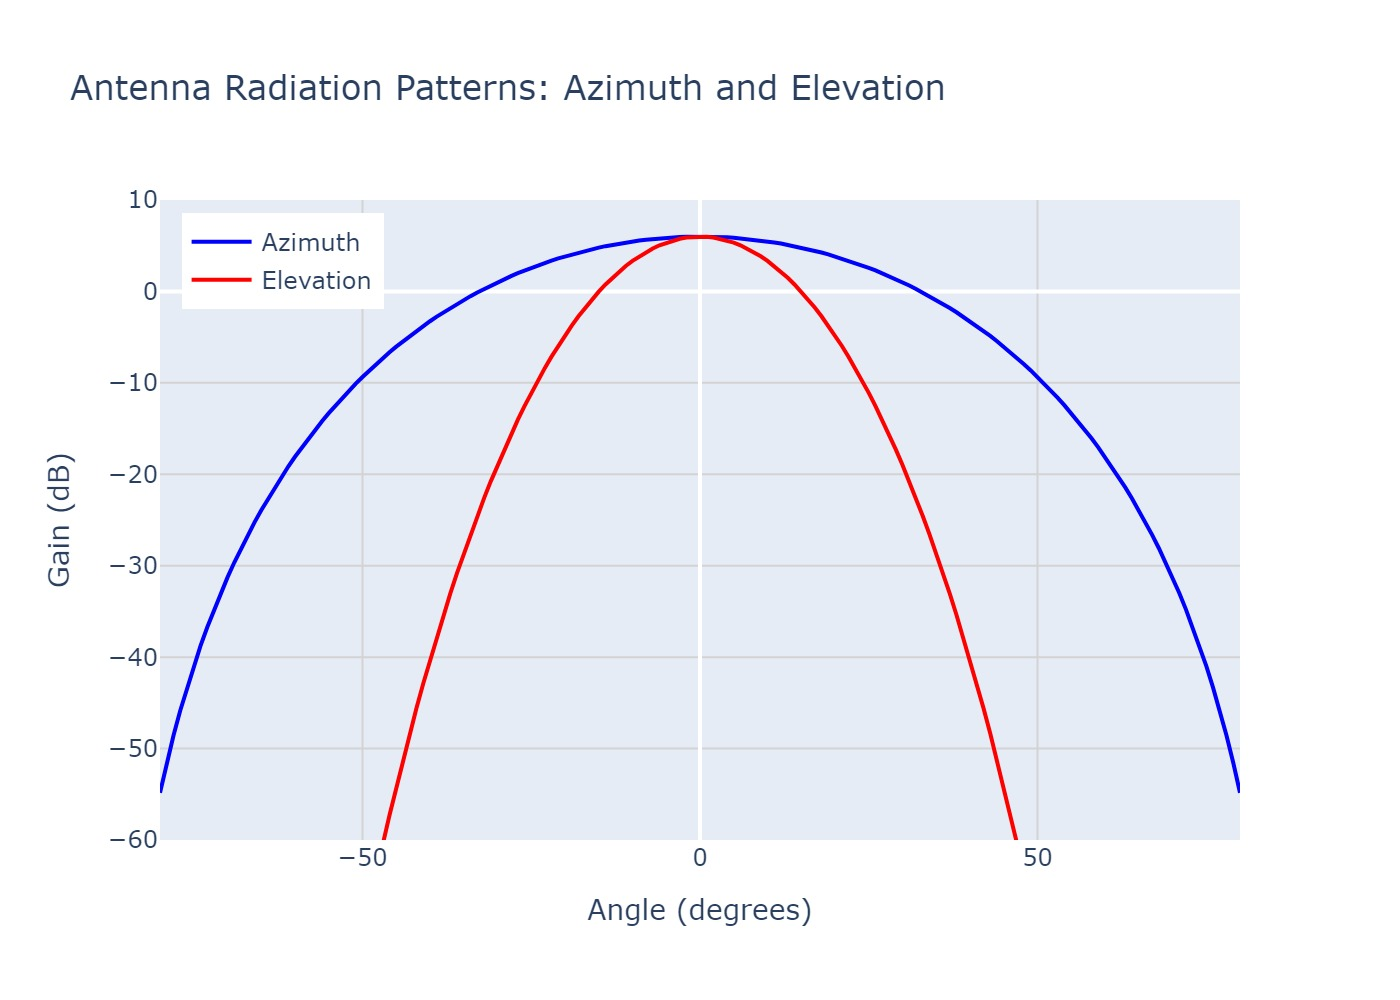

In [4]:
# Import plotting libraries
import plotly.graph_objs as go
from IPython.display import Image

# Create figure for antenna patterns
fig = go.Figure()

# Plot azimuth pattern
fig.add_trace(
    go.Scatter(
        x=az_angle,
        y=az_pattern,
        name="Azimuth",
        line=dict(color='blue', width=2),
    )
)

# Plot elevation pattern
fig.add_trace(
    go.Scatter(
        x=el_angle,
        y=el_pattern,
        name="Elevation",
        line=dict(color='red', width=2),
    )
)

# Configure plot layout
fig.update_layout(
    title="Antenna Radiation Patterns: Azimuth and Elevation",
    yaxis=dict(title="Gain (dB)", range=[-60, 10], gridcolor='lightgray'),
    xaxis=dict(title="Angle (degrees)", gridcolor='lightgray'),
    height=500,
    legend=dict(x=0.02, y=0.98),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Transmitter Channel Configuration

Define transmitter antenna location and radiation pattern.

**Channel Parameters:**

- **Location**: (0, 0, 0) → Origin (monostatic radar)
- **Azimuth Pattern**: Defined above (cos⁴ taper)
- **Elevation Pattern**: Defined above (cos²⁰ taper)
- **Polarization**: Default (linear, see [documentation](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-transmitter))
- **Modulation**: Default (unity, no pulse shaping)

The antenna patterns control how transmitted power is distributed in space, affecting target detection capability at different angles.

In [5]:
# Define transmitter channel with antenna patterns
tx_channel = dict(
    location=(0, 0, 0),           # Antenna position at origin
    azimuth_angle=az_angle,       # Azimuth angles array
    azimuth_pattern=az_pattern,   # Azimuth gain pattern (dB)
    elevation_angle=el_angle,     # Elevation angles array
    elevation_pattern=el_pattern, # Elevation gain pattern (dB)
)

### Transmitter Configuration

Configure FMCW transmitter with linear frequency chirp.

**FMCW Chirp Parameters:**

As shown in the diagram below, `f` and `t` define the waveform modulation:

```
|                       prp
|                  +-----------+
|
|            +---f[1]--->  /            /            /
|                         /            /            /
|                        /            /            /
|                       /            /            /
|                      /            /            /     ...
|                     /            /            /
|                    /            /            /
|                   /            /            /
|      +---f[0]--->/            /            /
|
|                  +-------+
|                 t[0]    t[1]
```

**Transmitter Parameters:**

- **Frequency Sweep**: 24.075-24.175 GHz (100 MHz bandwidth)
  - Start: f[0] = 24.075 GHz
  - End: f[1] = 24.175 GHz
  - Bandwidth: B = 100 MHz
  - Center: 24.125 GHz (K-band)
  - Range resolution: ΔR = c/(2B) = 1.5 m

- **Chirp Duration**: t = 80 μs
  - Active transmission time
  - Determines slope: B/T = 1.25 GHz/ms

- **Transmit Power**: 10 dBm (~10 mW)
  - Low power for safety and efficiency

- **Pulse Repetition Period (PRP)**: 100 μs
  - Time between chirp starts
  - PRF = 10 kHz
  - Must satisfy: PRP ≥ chirp duration (100 ≥ 80 ✓)

- **Number of Pulses**: 256 chirps
  - Total observation time: 256 × 100 μs = 25.6 ms
  - Enables Doppler processing
  - Velocity resolution: Δv = c/(2f_c × 25.6ms) ≈ 0.24 m/s

**Maximum Unambiguous Velocity:**

$$v_{max} = \frac{c}{4f_c \cdot PRP} = \frac{3 \times 10^8}{4 \times 24.125 \times 10^9 \times 100 \times 10^{-6}} \approx 31 \text{ m/s}$$

In [6]:
# Configure FMCW transmitter
tx = Transmitter(
    f=[24.075e9, 24.175e9],  # Frequency sweep: 24.075-24.175 GHz (100 MHz BW)
    t=80e-6,                 # Chirp duration: 80 μs
    tx_power=10,             # Transmit power: 10 dBm (~10 mW)
    prp=100e-6,              # Pulse repetition period: 100 μs (10 kHz PRF)
    pulses=256,              # Number of chirps: 256 (for Doppler processing)
    channels=[tx_channel],   # Transmitter antenna configuration
)

### Receiver Channel Configuration

Define receiver antenna location and radiation pattern.

**Channel Parameters:**

Similar to the transmitter, the receiver channel specifies:
- **Location**: (0, 0, 0) → Co-located with TX (monostatic)
- **Azimuth Pattern**: Same as transmitter
- **Elevation Pattern**: Same as transmitter

For monostatic radar, TX and RX share the same antenna pattern, simplifying the radar equation and providing symmetric coverage.

In [7]:
# Define receiver channel with antenna patterns
rx_channel = dict(
    location=(0, 0, 0),           # Antenna position at origin (co-located with TX)
    azimuth_angle=az_angle,       # Azimuth angles array
    azimuth_pattern=az_pattern,   # Azimuth gain pattern (dB)
    elevation_angle=el_angle,     # Elevation angles array
    elevation_pattern=el_pattern, # Elevation gain pattern (dB)
)

### Receiver Configuration

Configure receiver for baseband sampling and signal conditioning.

**Receiver Parameters:**

- **Sampling Rate (fs)**: 2 MHz
  - Captures beat frequencies from mixing
  - Determines maximum range: $R_{max} = \frac{f_s c T_c}{2B} = \frac{2 \times 10^6 \times 3 \times 10^8 \times 80 \times 10^{-6}}{2 \times 100 \times 10^6} = 240$ m

- **Noise Figure**: 12 dB
  - Standard performance for low-cost radar
  - Determines minimum detectable signal

- **RF Gain**: 20 dB
  - Low-noise amplifier (LNA) gain
  - Amplifies weak received signals

- **Load Resistor**: 500 Ω
  - Converts RF power to voltage
  - Impedance matching

- **Baseband Gain**: 30 dB
  - IF/baseband amplification
  - Total gain: 50 dB (20 + 30)

**Signal Chain:**

Antenna → LNA (20 dB) → Mixer → Baseband Amplifier (30 dB) → ADC (2 MHz)

In [8]:
# Configure radar receiver
rx = Receiver(
    fs=2e6,              # Sampling rate: 2 MHz (determines max range ~240 m)
    noise_figure=12,     # Noise figure: 12 dB
    rf_gain=20,          # RF gain: 20 dB (LNA)
    load_resistor=500,   # Load resistance: 500 Ω
    baseband_gain=30,    # Baseband gain: 30 dB (total gain: 50 dB)
    channels=[rx_channel],  # Receiver antenna configuration
)

### Create Radar System

Combine transmitter and receiver to form the complete FMCW radar.

In [9]:
# Create complete FMCW radar system
radar = Radar(transmitter=tx, receiver=rx)

## Target Configuration

Define three point targets with different ranges, velocities, and RCS values.

### Target Parameters

**Target Properties:**

Each target is defined by:
- **Location**: (x, y, z) coordinates in meters
- **Speed**: (v_x, v_y, v_z) velocity in m/s
- **RCS**: Radar cross section in dBsm
- **Phase**: Initial phase in degrees

**Target 1 (Far, Slow, Large):**
- **Location**: (200, 0, 0) m → 200m range
- **Velocity**: (-5, 0, 0) m/s → 5 m/s approaching
- **RCS**: 20 dBsm → 100 m² (large vehicle/truck)
- **Expected**: Low Doppler, long range

**Target 2 (Medium, Fast, Medium):**
- **Location**: (95, 20, 0) m → ~97m range (slight Y-offset)
- **Velocity**: (-50, 0, 0) m/s → 50 m/s approaching (180 km/h)
- **RCS**: 15 dBsm → 31.6 m² (medium vehicle)
- **Expected**: High Doppler, medium range

**Target 3 (Near, Moderate, Small):**
- **Location**: (30, -5, 0) m → ~30m range (slight Y-offset)
- **Velocity**: (-22, 0, 0) m/s → 22 m/s approaching (79 km/h)
- **RCS**: 5 dBsm → 3.16 m² (motorcycle/small vehicle)
- **Expected**: Moderate Doppler, short range

**Range-Velocity Space:**

These targets span different regions of the range-Doppler map:
- Range: 30-200 m
- Velocity: 5-50 m/s
- Clear separation in both dimensions

In [10]:
# Configure Target 1: Large, slow, far vehicle
target_1 = dict(
    location=(200, 0, 0),  # Position: 200m range
    speed=(-5, 0, 0),      # Velocity: -5 m/s (18 km/h approaching)
    rcs=20,                # Radar cross section: 20 dBsm (100 m² - truck)
    phase=0,               # Initial phase: 0 degrees
)

# Configure Target 2: Medium vehicle, high speed
target_2 = dict(
    location=(95, 20, 0),  # Position: ~97m range, 20m Y-offset
    speed=(-50, 0, 0),     # Velocity: -50 m/s (180 km/h approaching)
    rcs=15,                # Radar cross section: 15 dBsm (31.6 m² - car)
    phase=0,               # Initial phase: 0 degrees
)

# Configure Target 3: Small vehicle, moderate speed, close
target_3 = dict(
    location=(30, -5, 0),  # Position: ~30m range, -5m Y-offset
    speed=(-22, 0, 0),     # Velocity: -22 m/s (79 km/h approaching)
    rcs=5,                 # Radar cross section: 5 dBsm (3.16 m² - motorcycle)
    phase=0,               # Initial phase: 0 degrees
)

# Combine targets for simulation
targets = [target_1, target_2, target_3]

## Simulate Baseband Signals

Generate FMCW baseband I/Q signals containing target returns.

### Simulation Process

The simulator computes:
1. **Chirp Generation**: Linear frequency sweep per pulse
2. **Propagation**: Two-way delay and attenuation
3. **Target Interaction**: Reflection with RCS and phase
4. **Doppler Shift**: Frequency offset from target motion
5. **Beat Frequency**: Mixing TX and RX creates baseband
6. **Noise Addition**: Thermal noise from receiver

**Output Data Structure:**

- **Dimensions**: [channels, pulses, samples]
  - Channels: 1 (single TX/RX)
  - Pulses: 256 (chirps)
  - Samples: ~160 per chirp (2 MHz × 80 μs)

**Baseband Content:**

Each target creates a sinusoid at its beat frequency:
- Beat frequency ∝ range
- Phase change across chirps ∝ velocity
- Amplitude ∝ RCS and range

Complex I/Q format enables phase-coherent processing.

In [11]:
# Import radar simulator
from radarsimpy.simulator import sim_radar

# Simulate FMCW radar returns from three targets
data = sim_radar(radar, targets)

# Extract timestamp and baseband signals
timestamp = data["timestamp"]                # Time axis [1, 256, 160]
baseband = data["baseband"] + data["noise"]  # Complex I/Q with noise [1, 256, 160]

### Visualize Baseband I/Q Signals

Display time-domain baseband waveform for first chirp showing mixed beat frequencies.

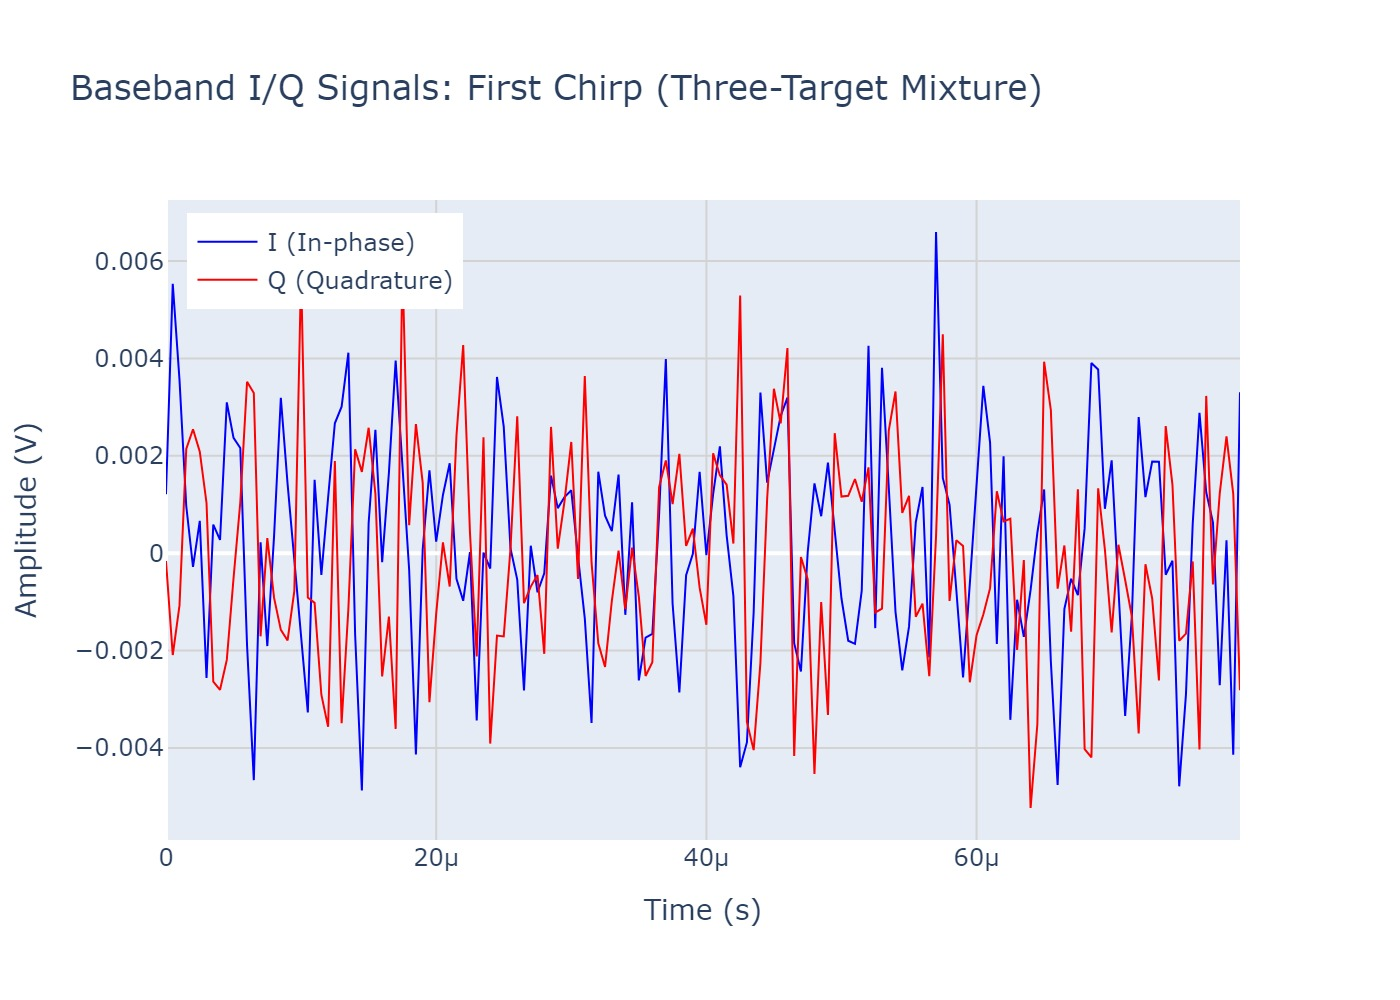

In [12]:
# Create figure for baseband visualization
fig = go.Figure()

# Plot In-phase (I) component of first chirp
fig.add_trace(
    go.Scatter(
        x=timestamp[0, 0, :],           # Time axis for chirp 0
        y=np.real(baseband[0, 0, :]),  # Real part (I channel)
        name="I (In-phase)",
        line=dict(color='blue', width=1),
    )
)

# Plot Quadrature (Q) component of first chirp
fig.add_trace(
    go.Scatter(
        x=timestamp[0, 0, :],           # Time axis for chirp 0
        y=np.imag(baseband[0, 0, :]),  # Imaginary part (Q channel)
        name="Q (Quadrature)",
        line=dict(color='red', width=1),
    )
)

# Configure plot layout
fig.update_layout(
    title="Baseband I/Q Signals: First Chirp (Three-Target Mixture)",
    yaxis=dict(title="Amplitude (V)", gridcolor='lightgray'),
    xaxis=dict(title="Time (s)", gridcolor='lightgray'),
    height=500,
    legend=dict(x=0.02, y=0.98),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Radar Signal Processing

Apply range and Doppler FFTs to extract target information from baseband signals.

### Range FFT (Fast-Time Processing)

**Range Compression:**

Apply FFT across samples within each chirp to extract range information.

**Process:**

1. **Windowing**: Apply Chebyshev window for sidelobe suppression
   - 60 dB sidelobe attenuation
   - Reduces spectral leakage

2. **FFT**: Transform time-domain to frequency-domain
   - Beat frequency → Range
   - One FFT per chirp

3. **Range Profiles**: 2D matrix [chirps, range bins]
   - Horizontal: Range
   - Vertical: Chirp index (time)

**Range Formula:**

$$R = \frac{f_b \cdot c \cdot T_c}{2B}$$

Where beat frequency $f_b$ is extracted from FFT bin.

In [13]:
# Import signal processing modules
from scipy import signal
import radarsimpy.processing as proc

# Create Chebyshev window for range FFT (60 dB sidelobe suppression)
range_window = signal.windows.chebwin(radar.sample_prop["samples_per_pulse"], at=60)

# Perform range FFT to compress chirp into range bins
# Input: baseband [1, 256, 160]
# Output: range_profile [1, 256, 160 range bins]
range_profile = proc.range_fft(baseband, range_window)

### Visualize Range Profiles

Display 3D surface showing range profiles across all chirps.

**Interpretation:**

- **X-axis**: Range (meters) → Target distance
- **Y-axis**: Chirp index (0-255) → Time progression
- **Z-axis**: Amplitude (dB) → Detection strength
- **Peaks**: Target locations at specific ranges
- **Vertical lines**: Stationary or slow-moving targets
- **Slanted lines**: Fast-moving targets (Doppler-induced range migration)

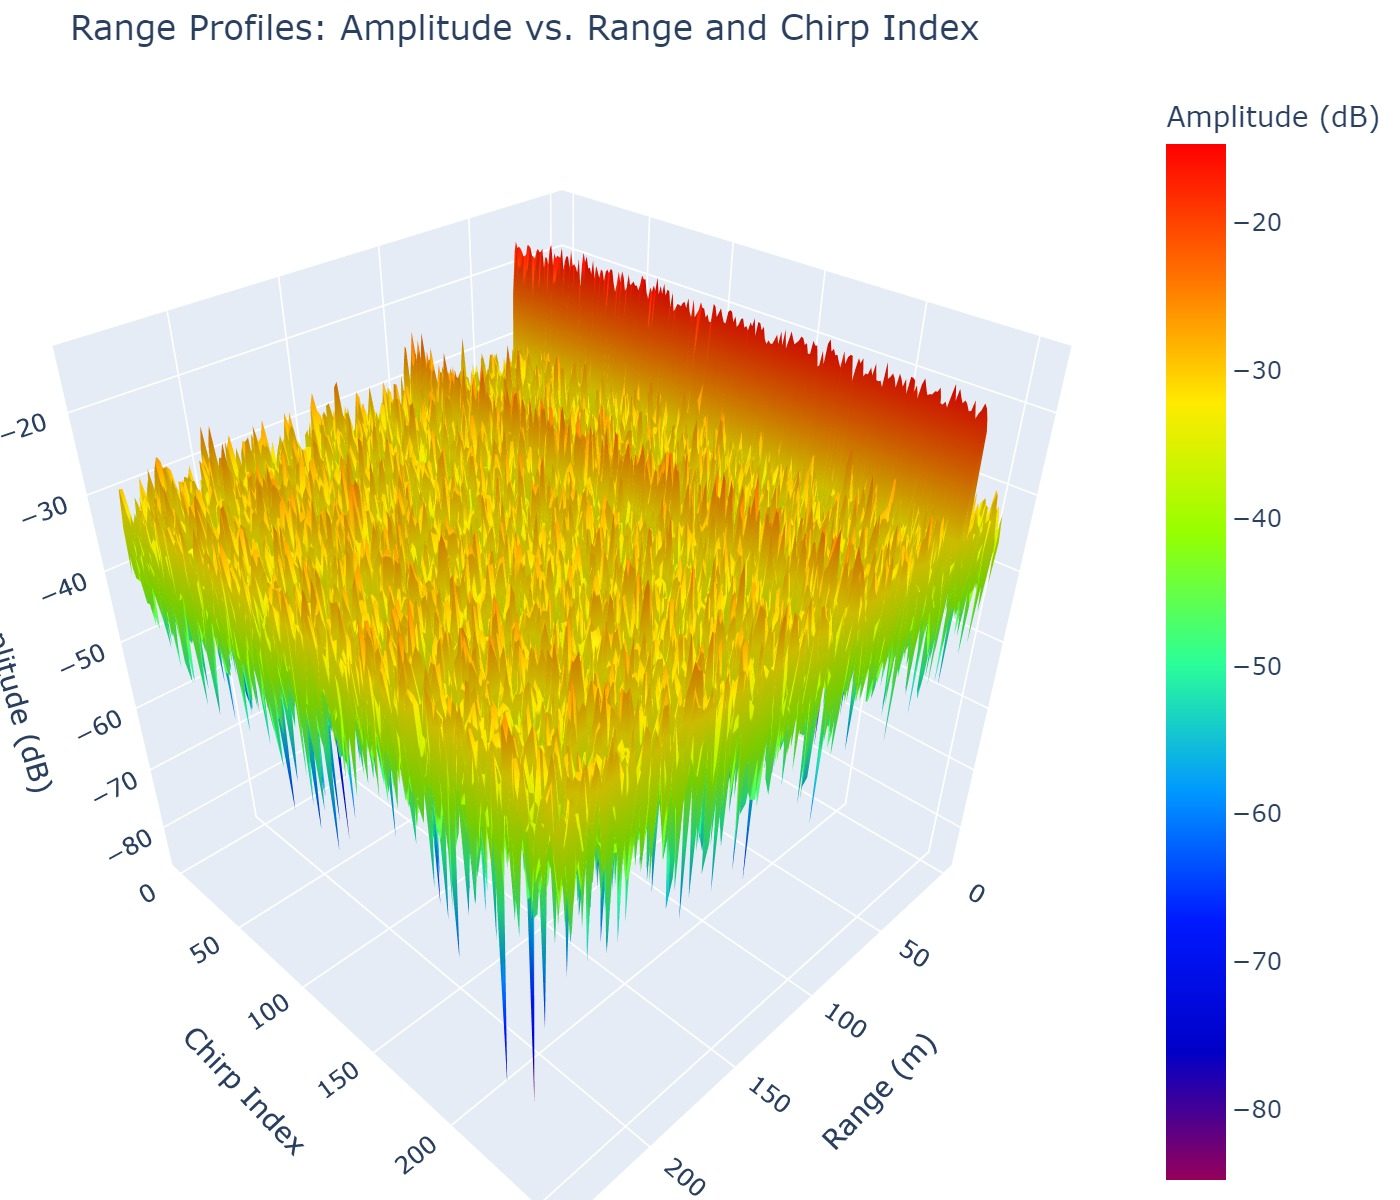

In [14]:
# Calculate maximum unambiguous range
max_range = (
    3e8  # Speed of light
    * radar.radar_prop["receiver"].bb_prop["fs"]  # Sampling rate
    * radar.radar_prop["transmitter"].waveform_prop["pulse_length"]  # Chirp duration
    / radar.radar_prop["transmitter"].waveform_prop["bandwidth"]  # Chirp bandwidth
    / 2  # Two-way propagation
)

# Create range axis
range_axis = np.linspace(
    0, max_range, radar.sample_prop["samples_per_pulse"], endpoint=False
)

# Create chirp index axis
doppler_axis = np.linspace(
    0,
    radar.radar_prop["transmitter"].waveform_prop["pulses"],
    radar.radar_prop["transmitter"].waveform_prop["pulses"],
    endpoint=False,
)

# Create 3D surface plot of range profiles
fig = go.Figure()

fig.add_trace(
    go.Surface(
        x=range_axis,                                  # Range axis (m)
        y=doppler_axis,                                # Chirp index
        z=20 * np.log10(np.abs(range_profile[0, :, :])),  # Amplitude (dB)
        colorscale="Rainbow",                          # Color scheme
        colorbar=dict(title="Amplitude (dB)"),
    )
)

# Configure 3D plot layout
fig.update_layout(
    title="Range Profiles: Amplitude vs. Range and Chirp Index",
    height=600,
    scene=dict(
        xaxis=dict(title="Range (m)"),
        yaxis=dict(title="Chirp Index"),
        zaxis=dict(title="Amplitude (dB)"),
        aspectmode="cube",
    ),
    margin=dict(l=0, r=0, b=0, t=40),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Doppler FFT (Slow-Time Processing)

**Velocity Extraction:**

Apply FFT across chirps (slow-time) to extract Doppler/velocity information.

**Process:**

1. **Windowing**: Apply Chebyshev window across chirps
   - 60 dB sidelobe attenuation
   - Applied vertically (chirp dimension)

2. **FFT**: Transform chirp-to-chirp phase to Doppler frequency
   - Phase change → Velocity
   - One FFT per range bin

3. **Range-Doppler Map**: 2D matrix [velocity bins, range bins]
   - Horizontal: Range
   - Vertical: Velocity
   - Amplitude: Target strength

**Doppler-to-Velocity Conversion:**

$$v = \frac{f_d \cdot c}{2f_c}$$

Where Doppler frequency $f_d$ is extracted from FFT bin.

In [15]:
# Create Chebyshev window for Doppler FFT (60 dB sidelobe suppression)
doppler_window = signal.windows.chebwin(
    radar.radar_prop["transmitter"].waveform_prop["pulses"], at=60
)

# Perform Doppler FFT to extract velocity information
# Input: range_profile [1, 256, 160]
# Output: range_doppler [1, 256 velocity bins, 160 range bins]
range_doppler = proc.doppler_fft(range_profile, doppler_window)

### Visualize Range-Doppler Map

Display 3D surface showing targets in range-velocity space.

**Interpretation:**

- **X-axis**: Range (meters) → Target distance
- **Y-axis**: Velocity (m/s) → Target radial velocity
  - Negative: Approaching (most automotive targets)
  - Zero: Stationary
  - Positive: Receding
- **Z-axis**: Amplitude (dB) → Detection strength
- **Peaks**: Individual targets at unique (range, velocity) positions

**Expected Targets:**

- **Peak 1**: ~200m range, -5 m/s (slow, far)
- **Peak 2**: ~95m range, -50 m/s (fast, medium) - May alias if beyond v_max
- **Peak 3**: ~30m range, -22 m/s (moderate, near)

This map enables simultaneous detection and measurement of multiple targets with different ranges and velocities.

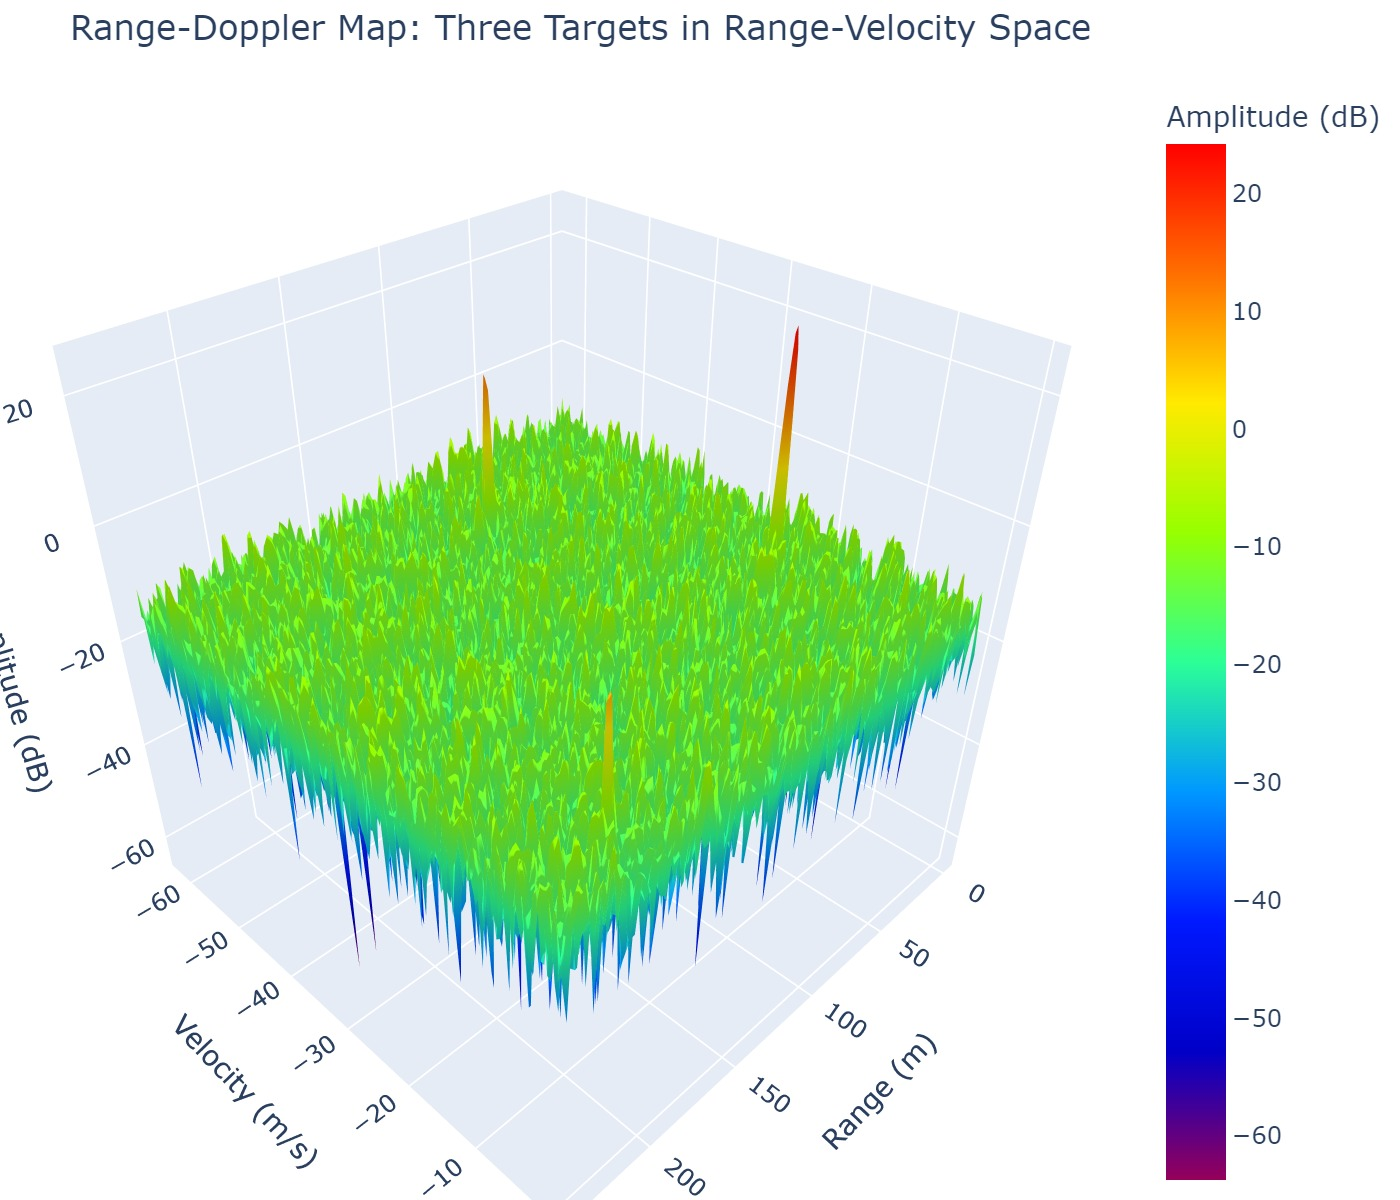

In [16]:
# Calculate maximum unambiguous velocity
unambiguous_speed = (
    3e8  # Speed of light
    / radar.radar_prop["transmitter"].waveform_prop["prp"][0]  # PRP
    / 24.125e9  # Carrier frequency (center)
    / 2  # Two-way Doppler
)

# Create range axis (same as before)
range_axis = np.linspace(
    0, max_range, radar.sample_prop["samples_per_pulse"], endpoint=False
)

# Create velocity axis (negative for approaching targets)
# Note: Doppler FFT output is typically arranged with approaching targets in negative bins
doppler_axis = np.linspace(
    -unambiguous_speed,  # Maximum approaching velocity
    0,                   # Zero velocity (stationary)
    radar.radar_prop["transmitter"].waveform_prop["pulses"],
    endpoint=False,
)

# Create 3D surface plot of range-Doppler map
fig = go.Figure()
fig.add_trace(
    go.Surface(
        x=range_axis,                                  # Range axis (m)
        y=doppler_axis,                                # Velocity axis (m/s)
        z=20 * np.log10(np.abs(range_doppler[0, :, :])),  # Amplitude (dB)
        colorscale="Rainbow",                          # Color scheme
        colorbar=dict(title="Amplitude (dB)"),
    )
)

# Configure 3D plot layout
fig.update_layout(
    title="Range-Doppler Map: Three Targets in Range-Velocity Space",
    height=600,
    scene=dict(
        xaxis=dict(title="Range (m)"),
        yaxis=dict(title="Velocity (m/s)"),
        zaxis=dict(title="Amplitude (dB)"),
        aspectmode="cube",
    ),
    margin=dict(l=0, r=0, b=0, t=40),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Summary

In this notebook, you learned how to implement and analyze FMCW radar using RadarSimPy:

### Key Takeaways

**1. FMCW Principles**
- Understood linear frequency modulation (chirp)
- Learned beat frequency for range: $f_b = 2RB/(cT_c)$
- Recognized Doppler shift for velocity: $f_d = 2v_r f_c/c$
- Appreciated simultaneous range and velocity measurement

**2. System Configuration**
- Defined realistic antenna patterns (cosine tapers)
- Configured 24.125 GHz center frequency (K-band)
- Set 100 MHz bandwidth (1.5 m range resolution)
- Used 256 chirps for Doppler processing

**3. Waveform Parameters**
- Chirp duration: 80 μs with linear sweep
- PRP: 100 μs (10 kHz PRF)
- Total observation: 25.6 ms
- Range resolution: 1.5 m, Velocity resolution: 0.24 m/s

**4. Multi-Target Scenario**
- Modeled three targets with different properties
- Range span: 30-200 m
- Velocity span: 5-50 m/s approaching
- RCS variation: 5-20 dBsm

**5. Baseband Signal Generation**
- Simulated complex I/Q with beat frequencies
- Multiple targets create superposition
- Added realistic receiver noise
- Preserved phase for coherent processing

**6. Range FFT Processing**
- Applied Chebyshev window (60 dB sidelobes)
- Extracted range profiles per chirp
- Compressed chirp to range bins
- Visualized targets at correct ranges

**7. Doppler FFT Processing**
- Applied second FFT across chirps
- Extracted velocity from phase change
- Generated 2D range-Doppler map
- Separated targets in range-velocity space

**8. Two-Dimensional Detection**
- Created range-Doppler map showing all targets
- Identified peaks at (range, velocity) coordinates
- Demonstrated multi-target resolution capability
- Validated FMCW measurement principles

### Experiment Further

Try modifying the parameters to explore different scenarios:

**1. Bandwidth Variations**:
- Increase to 500 MHz, 1 GHz, 4 GHz
- Observe range resolution: ΔR = c/(2B)
- Test target separation capability
- Understand bandwidth-resolution trade-off

**2. Chirp Count Studies**:
- Reduce to 64, 128 chirps
- Increase to 512, 1024 chirps
- Observe velocity resolution: Δv = c/(2f_c T_obs)
- Balance resolution vs. update rate

**3. PRP Optimization**:
- Decrease to 50 μs (faster frame rate)
- Increase to 200 μs (longer integration)
- Observe unambiguous velocity: v_max = c/(4f_c PRP)
- Test Doppler ambiguity limits

**4. Frequency Band**:
- Test 10 GHz, 77 GHz, 94 GHz
- Observe wavelength effects on Doppler
- Compare automotive vs. other bands
- Understand frequency allocation

**5. Target Velocity**:
- Add stationary target (0 m/s)
- Test very fast target (100 m/s)
- Observe Doppler aliasing beyond v_max
- Practice ambiguity resolution

**6. Target Spacing**:
- Place targets closer in range (5m separation)
- Test velocity separation (2 m/s difference)
- Observe resolution limits
- Understand windowing trade-offs

**7. Sampling Rate**:
- Increase to 5 MHz, 10 MHz
- Observe maximum range increase
- Test computational impact
- Optimize for scenario requirements

**8. Window Functions**:
- Try Hamming, Hanning, Blackman windows
- Compare sidelobe levels
- Observe resolution vs. sidelobe trade-off
- Test impact on weak target detection

**9. Antenna Patterns**:
- Modify beamwidth (narrower/wider)
- Change sidelobe levels
- Test off-boresight targets
- Understand gain-coverage trade-off

**10. Noise Level**:
- Vary noise figure: 6 dB, 15 dB
- Reduce target RCS: test weak targets
- Observe SNR impact on detection
- Practice threshold setting

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- RadarSimPy Simulator Module: https://radarsimx.github.io/radarsimpy/simulator.html
- FMCW Radar: Frequency-modulated continuous wave principles
- Beat Frequency: Range measurement from frequency difference
- Range-Doppler Processing: Two-dimensional FFT techniques
- Antenna Patterns: Radiation pattern modeling and effects
- Windowing Functions: Sidelobe suppression techniques
- Automotive Radar: ADAS and autonomous vehicle applications
- Signal Processing: FFT, filtering, and detection
- Resolution Limits: Range and velocity resolution analysis